# Jun 13th, 2022 (Node presnece figs for N=512 ROIs)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.network import *
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
from register.register import Register, reset_ants_img

fig_kws = {
    'transparent': False,
    'bbox_inches': 'tight',
    'dpi': 300,
}

fig_dir = pjoin(fig_base_dir, 'parcellation')
os.makedirs(fig_dir, exist_ok=True)
fig_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation'

In [3]:
mice = Mice(512)

task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 12, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 10},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'prep_data': True,
    'verbose': True,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

### Ca2

In [4]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

good_ca = {}
for key in mice.ca:
    props_ca['key'] = key
    bs_ca = Base(**props_ca)
    good = np.isnan(bs_ca.data).sum(1) == 0
    good_ca[key] = good
good_ca_arr = np.concatenate([
    np.expand_dims(v, 0)
    for v in good_ca.values()
]).astype(float)
good_ca_arr.shape

(110, 542)

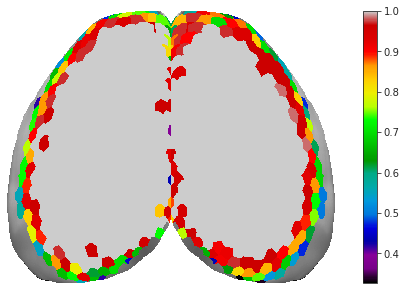

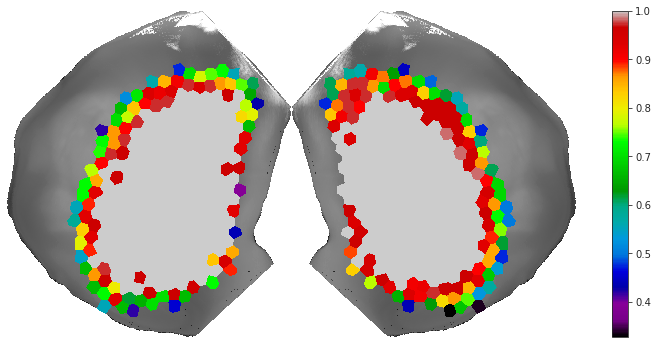

In [5]:
x = good_ca_arr.mean(0)

_ = bs_ca.show(
    data=x,
    vmin=x.min(),
    vmax=x.max(),
    proj='top',
    mask_thresh=0.001,
    cmap='nipy_spectral',
    cbar=True,
    figsize=(10, 5),
    add_disjoint=False,
)
_ = bs_ca.show(
    data=x,
    vmin=x.min(),
    vmax=x.max(),
    proj='flat',
    mask_thresh=0.001,
    cmap='nipy_spectral',
    cbar=True,
    figsize=(13, 6),
    add_disjoint=False,
)

In [6]:
base = Base(mice)
top, flat = base.load_top_flat()

obj_top = pjoin(mice.cfg.parcel_dir, 'parcel2d-top_10um.nii.gz')
obj_flat = pjoin(mice.cfg.parcel_dir, 'parcel2d-flat_10um.nii.gz')
obj_top = ants.image_read(obj_top, pixeltype='unsigned int').numpy()
obj_flat = ants.image_read(obj_flat, pixeltype='unsigned int').numpy()
regions_all = np.unique(obj_flat[obj_flat.nonzero()])

top, obj_top = filter_boundaries([top, obj_top], obj_top > 0)
flat, obj_flat = filter_boundaries([flat, obj_flat], obj_flat > 0)
len(regions_all)

1024

In [7]:
reg = Register(mice)
reg.set_mode('ca2')

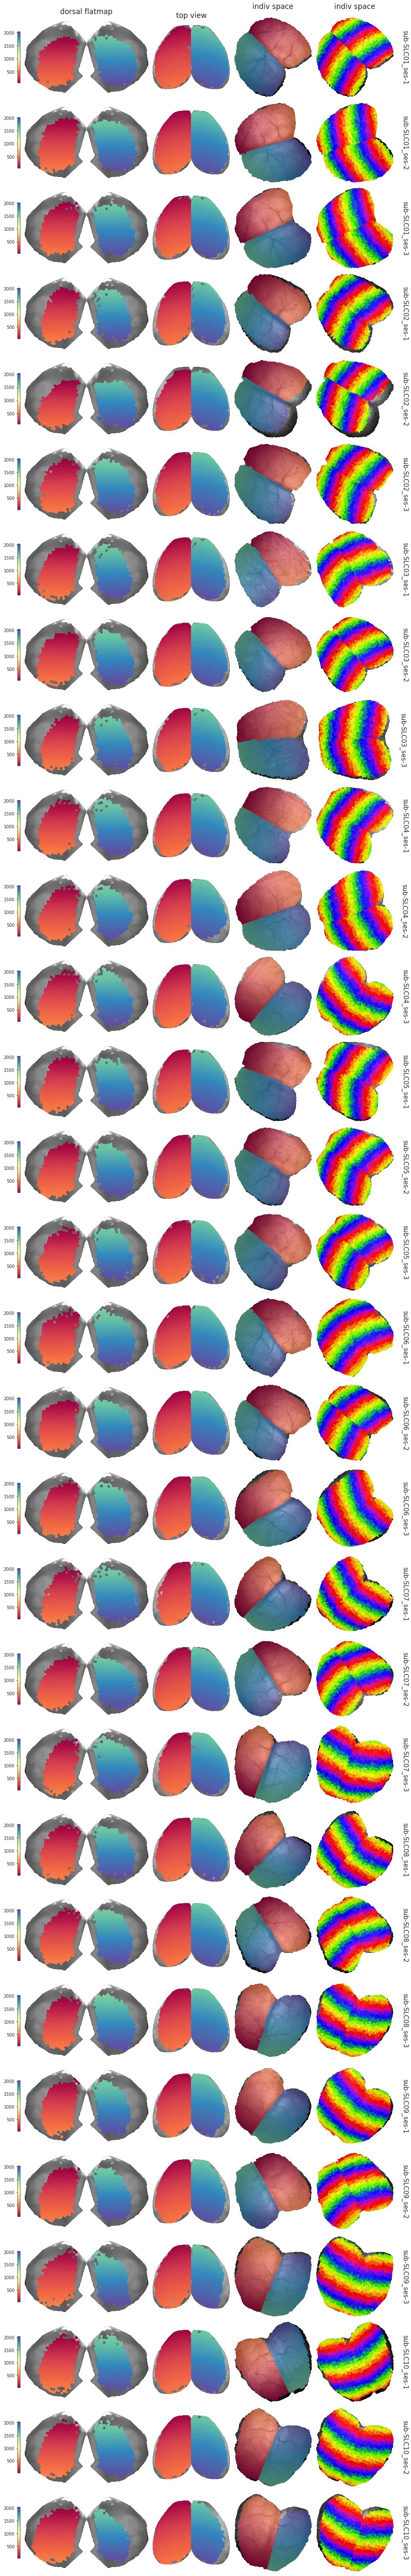

In [8]:
fig, axes = create_figure(
    nrows=len(mice.ref),
    ncols=5,
    figsize=(13.5, 2.8 * len(mice.ref)),
    width_ratios=[0.22] + [1.6] + [1] + [1] * 2,
)
region_presence = np.zeros((len(mice.ref), len(regions_all)))
for i, key in enumerate(mice.ref):
    mask = mice.mask2d[key].load_ants('unsigned int')
    ref = mice.ref[key].load_ants('float')
    ref = reset_ants_img(
        img=ref.numpy().squeeze(),
        spacing=ref.spacing[:2],
        origin=0, use_um=False,
    )
    ref = ants.resample_image_to_target(
        image=ref, target=mask,
        interp_type='linear',
    ).numpy()
    mask = mask.numpy().astype(bool)
    ref *= mask

    obj = reg.load_obj_masks(key)
    cols = obj['cols'].numpy()
    regions = np.unique(cols[cols.nonzero()])
    region_presence[i][np.isin(regions_all, regions)] = 1
    
    cols, ref, m = filter_boundaries([cols, ref, mask], mask=mask)

    axes[i, 1].imshow(mwh(flat == 0, flat), cmap='Greys_r')
    im = axes[i, 1].imshow(mwh(~np.isin(obj_flat, regions), obj_flat), cmap='Spectral')
    cbar = plt.colorbar(im, ax=axes[i, 0])
    cbar.ax.yaxis.set_ticks_position('left')

    axes[i, 2].imshow(mwh(top == 0, top), cmap='Greys_r')
    axes[i, 2].imshow(mwh(~np.isin(obj_top, regions), obj_top), cmap='Spectral')

    axes[i, 3].imshow(mwh(~m, ref), cmap='Greys_r')
    axes[i, 3].imshow(mwh(cols == 0, cols), alpha=0.65, cmap='Spectral')

    axes[i, 4].imshow(mwh(~m, ref), cmap='Greys_r')
    axes[i, 4].imshow(mwh(cols == 0, cols), alpha=0.9, cmap='prism')

    axes[i, 4].set_ylabel(key, fontsize=15, rotation=-90, labelpad=35)
    axes[i, 4].yaxis.set_label_position("right")
    axes[i, 4].yaxis.tick_right()

axes[0, 1].set_title('dorsal flatmap', fontsize=17, y=1.08)
axes[0, 2].set_title('top view', fontsize=17, y=1.08)
axes[0, 3].set_title('indiv space', fontsize=17, y=1.08)
axes[0, 4].set_title('indiv space', fontsize=17, y=1.08)

remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'node_presence_ca2.png'), **fig_kws)
fig.savefig(pjoin(fig_dir, 'node_presence_ca2.pdf'), **fig_kws)
plt.show()

In [9]:
region_presence.shape

(30, 1024)

In [19]:
region_presence_top = np.zeros(obj_top.shape)
region_presence_flat = np.zeros(obj_flat.shape)
for r, f in zip(regions_all, region_presence.mean(0)):
    region_presence_top[obj_top == r] = f
    region_presence_flat[obj_flat == r] = f

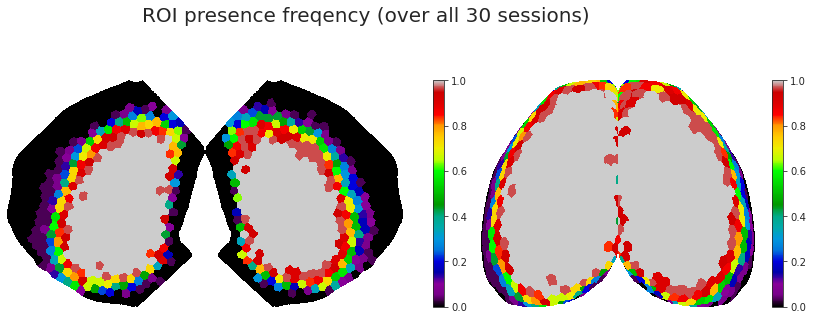

In [38]:
fig, axes = create_figure(1, 2, (13, 4), width_ratios=[1.8, 1])
im = axes[0].imshow(mwh(obj_flat == 0, region_presence_flat), cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(obj_top == 0, region_presence_top), cmap='nipy_spectral')
plt.colorbar(im, ax=axes[1])

fig.suptitle('ROI presence freqency (over all 30 sessions)', y=1.1, fontsize=20)
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'node_presence_freq_ca2.pdf'), **fig_kws)

plt.show()

### Bold

In [9]:
good_bo = {}
for key in mice.bold:
    props_bo['key'] = key
    bs_bo = Base(**props_bo)
    good = np.isnan(bs_bo.data).sum(1) == 0
    good_bo[key] = good
good_bo_arr = np.concatenate([
    np.expand_dims(v, 0)
    for v in good_bo.values()
]).astype(float)
good_bo_arr.shape

(114, 542)

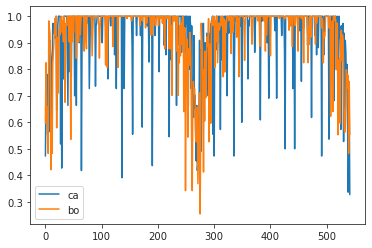

In [10]:
plt.plot(good_ca_arr.mean(0), label='ca')
plt.plot(good_bo_arr.mean(0), label='bo')
plt.legend()
plt.show()

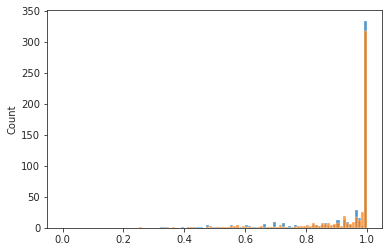

In [12]:
sns.histplot(good_ca_arr.mean(0), label='ca', color='C0', bins=np.linspace(0, 1, 101))
sns.histplot(good_bo_arr.mean(0), label='bo', color='C1', bins=np.linspace(0, 1, 101))
plt.show()

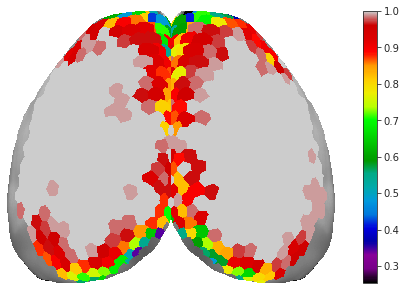

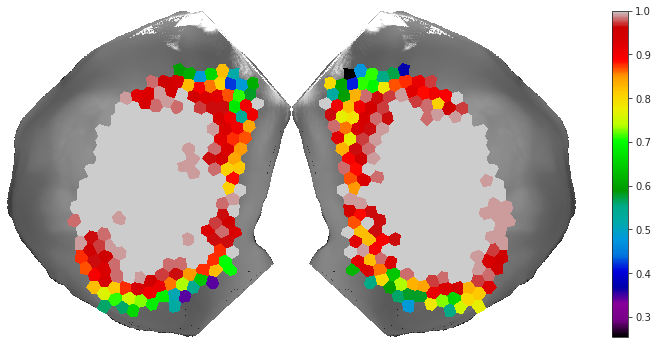

In [13]:
x = good_bo_arr.mean(0)

_ = bs_bo.show(
    data=x,
    vmin=x.min(),
    vmax=x.max(),
    proj='top',
    mask_thresh=0.001,
    cmap='nipy_spectral',
    cbar=True,
    figsize=(10, 5),
    add_disjoint=False,
)
_ = bs_bo.show(
    data=x,
    vmin=x.min(),
    vmax=x.max(),
    proj='flat',
    mask_thresh=0.001,
    cmap='nipy_spectral',
    cbar=True,
    figsize=(13, 6),
    add_disjoint=False,
)